# DNC Transit Analysis

Do democrats really love transit? (Was there more CTA ridership during that event?)

<span style="color:red">THIS NOTEBOOK WAS A STARTING POINT BUT IS NOW
DEPRECATED. </span>

<span style="color:red">ANYTHING INTERESTING FROM HERE IS ALREADY INCORPORATED IN panel.ipynb </span>

## Setup

In [1]:
import geopandas as gpd
from os.path import basename
import pandas as pd
import pyproj
from shapely.geometry import Point
from sodapy import Socrata
import s3fs
from tqdm import tqdm
from typing import Generator
from zipfile import ZipFile

In [2]:
TOTAL_RIDERSHIP_TABLE = "6iiy-9s97" # https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97
L_RIDERSHIP_TABLE = "5neh-572f" # https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f
BUS_RIDERSHIP_TABLE = "jyb9-n7fm" # https://data.cityofchicago.org/Transportation/CTA-Ridership-Bus-Routes-Daily-Totals-by-Route/jyb9-n7fm
DIVVY_RIDERSHIP_TABLE = "fg6s-gzvg" # https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg
DIVVY_SUB_RIDERSHIP_TABLE = "4am4-35ir" # https://data.cityofchicago.org/Transportation/Divvy-Trips-Subscriber-Only/4am4-35ir
L_STATIONS_TABLE = "8pix-ypme" # https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme
DIVVY_STATIONS_TABLE = "bbyy-e7gq" # https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations/bbyy-e7gq
BUS_ROUTES_TABLE = "6uva-a5ei" # https://data.cityofchicago.org/Transportation/CTA-Bus-Routes/6uva-a5ei
BUILDINGS_TABLE = "syp8-uezg" # https://data.cityofchicago.org/Buildings/buildings/syp8-uezg

DNC_START = "2024-08-19"
DNC_FINISH = "2024-08-22"
UNITED_CENTER = ((41,52,50,"N"), (87,40,27,"W"))

In [3]:
client = Socrata(
        "data.cityofchicago.org",
        app_token=None,
        timeout=10
    )

In [4]:
def _fix_coltypes(df: pd.DataFrame, client, resource, aliases=None):
    """
    Coerce pandas dtypes because SodaPy seems to return everything as strings.
    """
    # Iterate through columns because query may subset columns
    meta = client.get_metadata(resource)
    colnames = [c['fieldName'] for c in meta['columns']]
    coltypes = [c['dataTypeName'] for c in meta['columns']]
    coltypes = {c: ct for c,ct in zip(colnames, coltypes)}
    if aliases is not None:
        for kv in aliases.split(','):
            if ' AS ' in kv:
                k = kv.split(' AS ')[0].strip()
                v = kv.split(' AS ')[1].strip()
                coltypes[v] = coltypes[k]

    for col in df.columns:
        if coltypes[col] == 'calendar_date':
            df[col] = pd.to_datetime(df[col])
        elif coltypes[col] == 'number':
            df[col] = pd.to_numeric(df[col])
    return df

def _to_df(data: Generator, has_header=True):
    """
    Collect iterable of rows into a dataframe.
    """

    if has_header:
        header = list(next(data, {}).keys())
        df = pd.DataFrame.from_records(data, columns=header)
    else:
        df = pd.DataFrame.from_records(data)
    return df

def get_all(client, resource, **params):
    if "limit" in params.keys():
        # Sodapy doesn't allow limit with get_all :(
        data = iter(client.get(resource, **params))
    else:
        data = client.get_all(resource, **params)
    return (_to_df(data)
            .pipe(_fix_coltypes, client, resource))

def get_distinct(client, resource, colnames, **params):
    colnames = ', '.join(colnames)
    data = client.get(resource, select=f"distinct {colnames}", **params)
    return (_to_df(iter(data), has_header=False)
            .pipe(_fix_coltypes, client, resource, colnames))

## United Center

In [5]:
def dms_to_decimal(degrees, minutes, seconds, direction):
    decimal = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:  # South and West should be negative
        decimal = -decimal
    return decimal

uc_xy = dms_to_decimal(*UNITED_CENTER[1]), dms_to_decimal(*UNITED_CENTER[0])
uc_xy = Point(*uc_xy)

In [6]:
def buffer_query(location_column, dist):
    """Creates SoQL querystring for spatial comparison."""
    # within_circle(geom_col, lat, lng, dist)
    return f"within_circle({location_column}, {uc_xy.y}, {uc_xy.x}, {dist})"

### UC L Stations

In [7]:
uc_train_stations = get_all(client, L_STATIONS_TABLE, where=buffer_query("location", 800))

### UC Divy Stations

In [8]:
# DIVVY_STATIONS_TABLE and DIVVY_RIDERSHIP_TABLE don't have matching station IDs
# and the station names are imperfect foreign keys. So we'll just query the 
# stations from the ridership table directly.
cols = ['station_id','station_name','location']
from_cols = [f"from_{x} AS {x}" for x in cols]
to_cols = [f"to_{x} AS {x}" for x in cols]
uc_bike_stations_from = get_distinct(client, DIVVY_RIDERSHIP_TABLE, from_cols, where=buffer_query("from_location", 800))
uc_bike_stations_to = get_distinct(client, DIVVY_RIDERSHIP_TABLE, to_cols, where=buffer_query("to_location", 800))
uc_bike_stations = pd.concat([uc_bike_stations_from,uc_bike_stations_to], ignore_index=True).drop_duplicates('station_id')

## Total Ridership

In [9]:
total_rides = get_all(client, TOTAL_RIDERSHIP_TABLE)

<Axes: xlabel='service_date'>

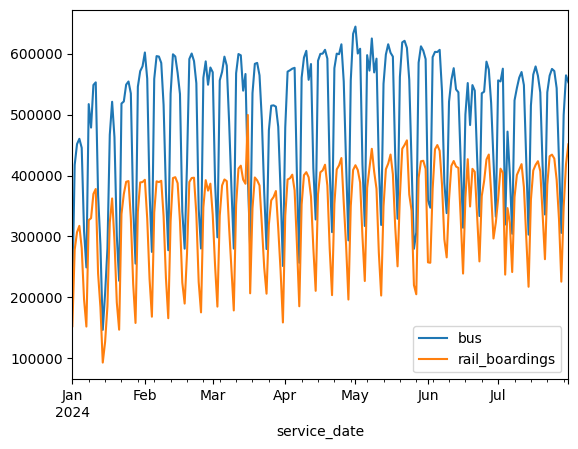

In [10]:
ax = total_rides.sort_values('service_date').query('service_date.dt.year >= 2024').plot(x='service_date',y='bus')
total_rides.sort_values('service_date').query('service_date.dt.year >= 2024').plot(x='service_date',y='rail_boardings', ax=ax)

## L Station Ridership

### Airport L Boardings

In [11]:
stations = get_distinct(client, L_RIDERSHIP_TABLE, ['station_id','stationname'])

In [12]:
# What are the ID's for OHare and Midway?
stations[stations.stationname.str.lower().str.contains('airport')]

,station_id,stationname
85,40890,O'Hare Airport
89,40930,Midway Airport


In [13]:
OHARE_STATION_ID = 40890
MIDWAY_STATION_ID = 40930

ohare_rides = get_all(client, L_RIDERSHIP_TABLE, where=f"station_id = {OHARE_STATION_ID}").sort_values('date')
midway_rides = get_all(client, L_RIDERSHIP_TABLE, where=f"station_id = {MIDWAY_STATION_ID}").sort_values('date')
airport_rides = pd.concat([ohare_rides, midway_rides], ignore_index=True)

<Axes: xlabel='date'>

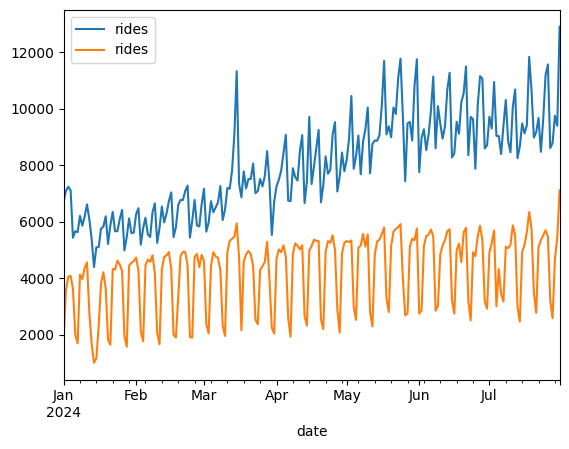

In [14]:
ax = ohare_rides.query('date.dt.year == 2024').plot(x='date',y='rides')
midway_rides.query('date.dt.year == 2024').plot(x='date',y='rides', ax=ax)

### United Center Boardings

In [15]:
uc_train_ids = ', '.join(uc_train_stations['map_id'].unique().astype(str))
uc_train_rides = get_all(client, L_RIDERSHIP_TABLE, where=f"station_id in ({uc_train_ids})").sort_values('date')

<Axes: xlabel='date'>

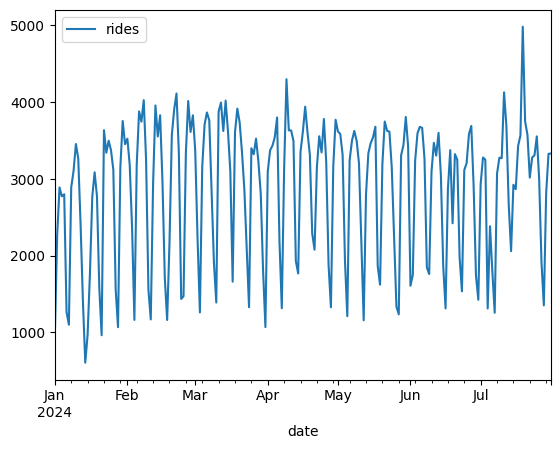

In [16]:
uc_train_rides.groupby('date')['rides'].sum().reset_index().query('date.dt.year == 2024').plot(x='date',y='rides')

### L Panel

In [68]:
def get_train_panel(point, dist):
    stations = get_all(client, L_STATIONS_TABLE)
    stations['latitude'] = stations['location'].apply(lambda x: x['latitude'])
    stations['longitude'] = stations['location'].apply(lambda x: x['longitude'])
    station_uc = classify_stations(stations, "latitude", "longitude", "geometry", "map_id", point, meter_to_foot(dist))
    train_panel = get_all(client, L_RIDERSHIP_TABLE, 
                          select="station_id,date,daytype,rides",
                          where="date_extract_y(date) = 2024")
    train_panel['date'] = pd.to_datetime(train_panel['date'])
    train_panel['is_uc'] = train_panel['station_id'].map(station_uc)
    return train_panel

train_panel = get_train_panel(uc_xy, 800)

## Bus Line Ridership

In [55]:
from shapely.geometry import shape

def get_bus_panel(point, dist):
    routes = get_all(client, BUS_ROUTES_TABLE, select="the_geom, route, name")
    routes['geometry'] = routes['the_geom'].apply(shape)
    route_uc = classify_stations(routes, None, None, "geometry", "route", point, meter_to_foot(dist))
    panel = get_all(client, BUS_RIDERSHIP_TABLE, 
                          select="route,date,daytype,rides",
                          where="date_extract_y(date) = 2024")
    panel['date'] = pd.to_datetime(panel['date'])
    panel['is_uc'] = panel['route'].map(route_uc)
    return panel

bus_panel = get_bus_panel(uc_xy, 800)

## Divy Station Ridership

In [17]:
# This method is slightly faster than querying "WHERE STATION_ID IN (...)"
uc_bike_rides_from = get_all(client, DIVVY_RIDERSHIP_TABLE, where=buffer_query("from_location", 800))
uc_bike_rides_to = get_all(client, DIVVY_RIDERSHIP_TABLE, where=buffer_query("to_location", 800))
uc_bike_rides = pd.concat([uc_bike_rides_from,uc_bike_rides_to], ignore_index=True).drop_duplicates('trip_id')

In [18]:
# THIS DATA ONLY GOES UP TO 2019!!!
uc_bike_rides.start_time.max()

Timestamp('2019-12-31 16:39:36')

### Read Divvy Data

Tools used:
- s3fs to access the s3 bucket like a filesystem,
- zipfile to interact with the files in the bucket,
- regular pandas to download each whole file and spatially query it.

Here's why:
- there is a lot of annoying schema drift over time
    - multiple file formats, column names, data types
- there are multiple data files per csv
    - some are denormalized, some are normalized
    - some are redundant data in different formats
- the files are individually pretty small, 50MB at most, 3.6GB in total

That said, I've kept some commented exploratory cells that explore more complicated libraries.

In [19]:
s3 = s3fs.S3FileSystem(anon=True)

def get_bucket_paths() -> Generator:
    """
    Returns pairs of s3://filepaths and membername.csv in the bucket.
    
    Handles:
    - ignoring irrelevant files in the bucket, like the index.html page
    - ignoring irrelevant member files like system files in the ZIP files
    - including multiple valid CSVs per ZIP like multiple quarters
    - some station_ids are normalized and some aren't
    """
    s3_paths = [f"s3://{x}" for x in s3.glob('divvy-tripdata/*.zip')]
    csv_filter = lambda x: x.endswith('.csv') and 'MACOSX' not in x
    shp_filter = lambda x: x.endswith('.shp.zip') and 'MACOSX' not in x
    trip_filter = lambda x: 'trip' in basename(x.lower()) and csv_filter(x)
    station_filter = lambda x: 'station' in basename(x.lower()) and (csv_filter(x) or shp_filter(x))
    for s3_path in s3_paths:
        with s3.open(s3_path, mode='rb') as s3f:
            with ZipFile(s3f) as zf:
                station_path = filter(station_filter, zf.namelist())
                station_path = sorted(station_path, key=csv_filter)
                station_path = station_path.pop() if station_path else None
                for csv_path in filter(trip_filter, zf.namelist()):
                    yield (s3_path, csv_path, station_path)
                if not any(map(csv_filter, zf.namelist())):
                    print(f"WARNING: Did not find csv in {s3_path}")

def station_schema(df):
    """Helper function to unify schema drift."""
    return (
        df.rename(columns= lambda x: x.lower())
          .rename(columns = {
            "lat": "latitude",
            "long": "longitude",
            "id_list": "station_id",
            "id": "station_id",
            "online date": "online_date"
        }))

def trip_schema(df):
    """Helper function to unify schema drift."""
    return (
        df.rename(columns={
            '01 - Rental Details Rental ID': 'ride_id',
            '01 - Rental Details Local Start Time': 'start_time',
            '01 - Rental Details Local End Time': 'end_time', 
            '01 - Rental Details Bike ID': 'bike_id',
            '01 - Rental Details Duration In Seconds Uncapped': 'tripduration',
            '03 - Rental Start Station ID': 'start_station_id',
            '03 - Rental Start Station Name': 'start_station_name',
            '02 - Rental End Station ID': 'end_station_id',
            '02 - Rental End Station Name': 'end_station_name',
            'User Type': 'user_type',
            'Member Gender': 'gender',
            '05 - Member Details Member Birthday Year': 'birthyear'
            })
          .rename(columns= lambda x: x.lower())
          .rename(columns = {
            'from_lng': 'start_lng',
            'from_lat': 'start_lat',
            'to_lng': 'end_lng',
            'to_lat': 'end_lat',
            'trip_id': 'ride_id',
            'from_station_id': 'start_station_id',
            'to_station_id': 'end_station_id',
            'from_station_name': 'start_station_name',
            'to_station_name': 'end_station_name',
            'starttime': 'start_time',
            'stoptime': 'end_time',
            'stop_time': 'end_time',
            'started_at': 'start_time',
            'ended_at': 'end_time',
            'bikeid': 'bike_id',
            'tripduration': 'trip_duration',
            'usertype': 'user_type',
            'member_casual': 'user_type',
            'duration': 'trip_duration',
            'birthday': 'birthyear',
          }))

def read_trip_file(fp):
    """Helper function to unify schema drift."""
    df = pd.read_csv(fp).pipe(trip_schema)
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
    return df

def read_station_file(fp):
    """Helper function to unify schema drift."""
    if fp.name.endswith(".csv"):
        df = pd.read_csv(fp).pipe(station_schema)
    else:
        df = gpd.read_file(fp).pipe(station_schema)
    return df

def create_geodf(df, lng_col, lat_col, loc_col):
    """Helper function to compute projected geometries."""
    crs = df.crs if isinstance(df, gpd.GeoDataFrame) else pyproj.CRS('EPSG:4326')
    projected_crs = crs if crs.is_projected else pyproj.CRS("EPSG:3435")
    if loc_col not in df.columns:
        df = df.assign(**{loc_col: gpd.points_from_xy(df[lng_col], df[lat_col], crs=crs)})
    return gpd.GeoDataFrame(df, geometry=loc_col, crs=crs).to_crs(projected_crs)

def geofilter(df, lng_col, lat_col, loc_col, point, dist):
    """Helper function to filter rows within dist meters of point."""
    gdf = create_geodf(df, lng_col, lat_col, loc_col)
    point = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(gdf.crs)
    return gdf[gdf.geometry.dwithin(point[0], dist)]

def station_geofilter(trip_df, station_df, point, dist):
    """Top-level function to sptially filter normalized dataframes."""
    filtered_stations = geofilter(station_df, 'longitude', 'latitude', 'geometry', point, dist)[['station_id']]
    df_from = trip_df.merge(filtered_stations, left_on='start_station_id', right_on='station_id')
    df_to = trip_df.merge(filtered_stations, left_on='end_station_id', right_on='station_id')
    return pd.concat([df_from, df_to], ignore_index=True).drop(columns=['station_id']).drop_duplicates('ride_id')
    
def trip_geofilter(trip_df, station_df, point, dist):
    """
    Top-level function to spatially filter single denormalized dataframe.
    Takes station_df as a last resort when denormalized trip_df is incomplete.
    """
    if 'start_lng' in trip_df.columns:
        df_from = geofilter(trip_df, 'start_lng', 'start_lat', 'start_loc', point, dist)
        df_to = geofilter(trip_df, 'end_lng', 'end_lat', 'end_loc', point, dist)
        return pd.concat([df_from, df_to], ignore_index=True).drop_duplicates('ride_id')
    else:
        # Coerce the dtypes to match to avoid a warning.
        # In the bad case when dtypes dont match, this should still return empty.
        # In the good case when dtypes already match, it shouldn't affect outcome either.
        trip_df['start_station_id'] = trip_df['start_station_id'].astype(station_df['station_id'].dtype)
        trip_df['end_station_id'] = trip_df['end_station_id'].astype(station_df['station_id'].dtype)
        return station_geofilter(trip_df, station_df, point, dist)
    
def meter_to_foot(x):
    return x * 3.281

#### With s3fs > ZipFile > Pandas

In [20]:
# # Collect all stations into one dataframe:
# # We will use these when zipfiles do not contain any long/lat data.
# all_bike_stations = []
# for zip_path, trip_path, station_path in tqdm(get_bucket_paths()):
#     if station_path is not None:
#         with (s3.open(zip_path, mode='rb') as s3f, 
#             ZipFile(s3f) as zf, 
#             zf.open(station_path) as stationf):
#             df = geofilter(read_station_file(stationf), 'longitude', 'latitude', 'geometry', uc_xy, meter_to_foot(800))
#             all_bike_stations.append(df)
# all_bike_stations = [x.to_crs(all_bike_stations[0].crs) for x in all_bike_stations]
# all_bike_stations = pd.concat(all_bike_stations, ignore_index=True).drop_duplicates('station_id')

In [21]:
# # Now collect the bike data. 
# # We prefer using sibling station.csv when possible, 
# # otherwise the denormalized trip lat/longs,
# # finally the concatenated station lat/longs.
# # We try to avoid the last case because station ids may not be stable over time.
# uc_bike_rides = []
# for zip_path, trip_path, station_path in tqdm(get_bucket_paths()):
#     with s3.open(zip_path, mode='rb') as s3f, ZipFile(s3f) as zf:
#         if station_path is None:
#             with zf.open(trip_path) as tripf:
#                 df = trip_geofilter(read_trip_file(tripf), all_bike_stations, uc_xy, meter_to_foot(800))
#         else:
#             with zf.open(trip_path) as tripf, zf.open(station_path) as stationf:
#                 df = station_geofilter(read_trip_file(tripf), read_station_file(stationf), uc_xy, meter_to_foot(800))
#         if df.empty:
#             print(f"WARNING: no UC rides in {trip_path}")
#         uc_bike_rides.append(df)
# uc_bike_rides = pd.concat(uc_bike_rides, ignore_index=True).drop_duplicates('ride_id')

#### With PySpark 

PySpark requires a JVM, which I don't want to install, since I'm running this on my personal computer.

In [22]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("DNCTransit").master("local").getOrCreate()

#### With Dask

In [23]:
# # Ideally I'd like to just glob the zip files.
# ddf = dd.read_csv("s3://divvy-tripdata/*.zip",
#                  storage_options={'anon': True},
#                  dtype="str")
# # But this is getting utf-8 encoding issues... I think it's reading the non-csv zipped files.
# # Tried globbing zip://*.csv::s3://divvy-tripdata/*.zip but fsspec doesn't support complex globs.

### Analyze Divvy Data

In [24]:
# plot_data = (uc_bike_rides
#     .assign(start_day = uc_bike_rides['start_time'].dt.date)
#     .groupby('start_day',sort=True)['ride_id']
#     .count().rename('rides').reset_index()
#     .assign(start_day = lambda x: pd.to_datetime(x['start_day'])))
# plot_data.query('start_day.dt.year >= 2024').plot(x='start_day',y='rides')

### Panel Divvy Data

In [25]:
def classify_stations(df, lng_col, lat_col, loc_col, station_col, point, dist):
    df = df.drop_duplicates(station_col)
    gdf = create_geodf(df, lng_col, lat_col, loc_col)
    point = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(gdf.crs)
    gdf["is_uc"] = gdf[loc_col].dwithin(point[0], dist)
    return gdf.set_index(station_col)['is_uc']

def divvy_panel(trip_df, station_df, point, dist):
    """Top-level function to create panel dataset"""
    trip_df['start_date'] = trip_df['start_time'].dt.date
    trip_df['end_date'] = trip_df['end_time'].dt.date
    if 'start_lng' in trip_df.columns:
        start_uc = classify_stations(trip_df, "start_lng", "start_lat", "start_loc", "start_station_id", point, dist)
        end_uc = classify_stations(trip_df, "end_lng", "end_lat", "end_loc", "end_station_id", point, dist)
        trip_df['start_is_uc'] = trip_df['start_station_id'].map(start_uc) 
        trip_df['end_is_uc'] = trip_df['end_station_id'].map(end_uc)
    else:
        trip_df['start_station_id'] = trip_df['start_station_id'].astype(station_df['station_id'].dtype)
        trip_df['end_station_id'] = trip_df['end_station_id'].astype(station_df['station_id'].dtype)
        is_uc = classify_stations(station_df, "longitude", "latitude", "geometry", "station_id", point, dist)
        trip_df['start_is_uc'] = trip_df['start_station_id'].map(is_uc) 
        trip_df['end_is_uc'] = trip_df['end_station_id'].map(is_uc)
    start_panel = trip_df.rename(columns=lambda x: x.replace('start_',''))[['station_id','date','is_uc']]
    end_panel = trip_df.rename(columns=lambda x: x.replace('end_',''))[['station_id','date','is_uc']]
    panel = pd.concat([start_panel, end_panel], ignore_index=True)
    panel = panel.value_counts(['station_id','date','is_uc']).rename('rides').reset_index()
    panel['date'] = pd.to_datetime(panel['date'])
    return panel

In [26]:
# from functools import lru_cache
# @lru_cache
def cache_station(zip_path, station_path):
    with (s3.open(zip_path, mode='rb') as s3f, ZipFile(s3f) as zf, zf.open(station_path) as stationf):
        df = read_station_file(stationf)
        df = create_geodf(df, "longitude","latitude","geometry")
        return df

In [27]:
all_bike_stations = []
for zip_path, _, station_path in tqdm(get_bucket_paths()):
    if station_path is not None:
        df = cache_station(zip_path, station_path)
        all_bike_stations.append(df)
all_bike_stations = [x.to_crs(all_bike_stations[0].crs) for x in all_bike_stations]
all_bike_stations = pd.concat(all_bike_stations, ignore_index=True).drop_duplicates('station_id')

84it [00:43,  1.94it/s]


In [28]:
# @lru_cache
def cache_trip(zip_path, trip_path, station_path):
    with s3.open(zip_path, mode='rb') as s3f, ZipFile(s3f) as zf:
        if station_path is None:
            with zf.open(trip_path) as tripf:
                df = divvy_panel(read_trip_file(tripf), all_bike_stations, uc_xy, meter_to_foot(800))
        else:
            with zf.open(trip_path) as tripf, zf.open(station_path) as stationf:
                df = divvy_panel(read_trip_file(tripf), read_station_file(stationf), uc_xy, meter_to_foot(800))
        return df

In [29]:
bike_panel = []
for zip_path, trip_path, station_path in tqdm(get_bucket_paths()):
    df = cache_trip(zip_path, trip_path, station_path)
    bike_panel.append(df)
bike_panel = pd.concat(bike_panel, ignore_index=True)
bike_panel = bike_panel.groupby(['station_id','date','is_uc'])['rides'].max().reset_index()

54it [12:23, 12.37s/it]/var/folders/tb/97cmcv3d7756wm9ypglr63nw0000gn/T/ipykernel_1552/256106570.py:84: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp).pipe(trip_schema)
55it [12:33, 11.88s/it]/Users/eric/Dev/DNCTransit/.venv/lib/python3.12/site-packages/shapely/predicates.py:1059: RuntimeWarning: overflow encountered in dwithin
  return lib.dwithin(a, b, distance, **kwargs)
84it [24:13, 17.30s/it]


#### Analyze Panel

<Axes: xlabel='date'>

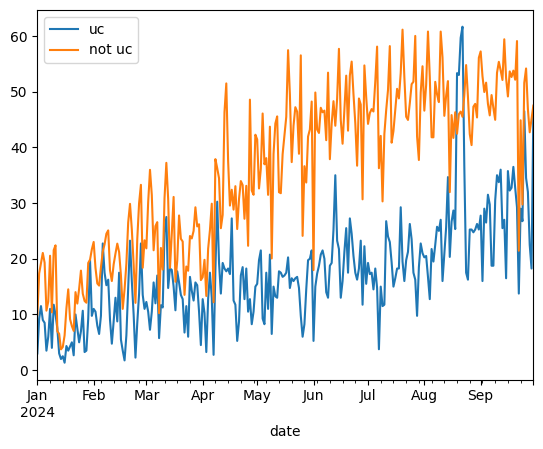

In [57]:
plot_data = bike_panel.groupby(['date','is_uc'])['rides'].mean().reset_index()
plot_data['date'] = pd.to_datetime(plot_data['date'])
ax = plot_data.query('is_uc').query('date.dt.year >= 2024').rename(columns={'rides':'uc'}).plot(x='date',y='uc')
plot_data.query('~is_uc').query('date.dt.year >= 2024').rename(columns={'rides':'not uc'}).plot(x='date',y='not uc',ax=ax)

## Transit Panel

In [65]:
# daytypes = pd.concat([bus_panel[['date','daytype']],train_panel[['date','daytype']]],ignore_index=True)
# daytypes = daytypes.groupby('date')['daytype'].first()
# bike_panel['date'] = pd.to_datetime(bike_panel['date'])
# bike_panel['daytype'] = bike_panel['date'].map(daytypes)

In [70]:
# transit_panel = pd.concat([
#     bus_panel.rename(columns={'route':'station_id'}),
#     train_panel,
#     bike_panel
# ],ignore_index=True)

In [72]:
# transit_panel.query('date.dt.year == 2024').to_csv("transit_panel.csv")

In [11]:
transit_panel = pd.read_csv("transit_panel.csv")

/var/folders/tb/97cmcv3d7756wm9ypglr63nw0000gn/T/ipykernel_695/2445814271.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  transit_panel = pd.read_csv("transit_panel.csv")


In [12]:
transit_panel.head()


,Unnamed: 0,station_id,date,daytype,rides,is_uc,uc
0,0,126,2024-01-22,W,3076,True,NaN
1,1,126,2024-01-23,W,3337,True,NaN
2,2,126,2024-01-24,W,3738,True,NaN
3,3,126,2024-01-25,W,3811,True,NaN
4,4,126,2024-01-26,W,3335,True,NaN
